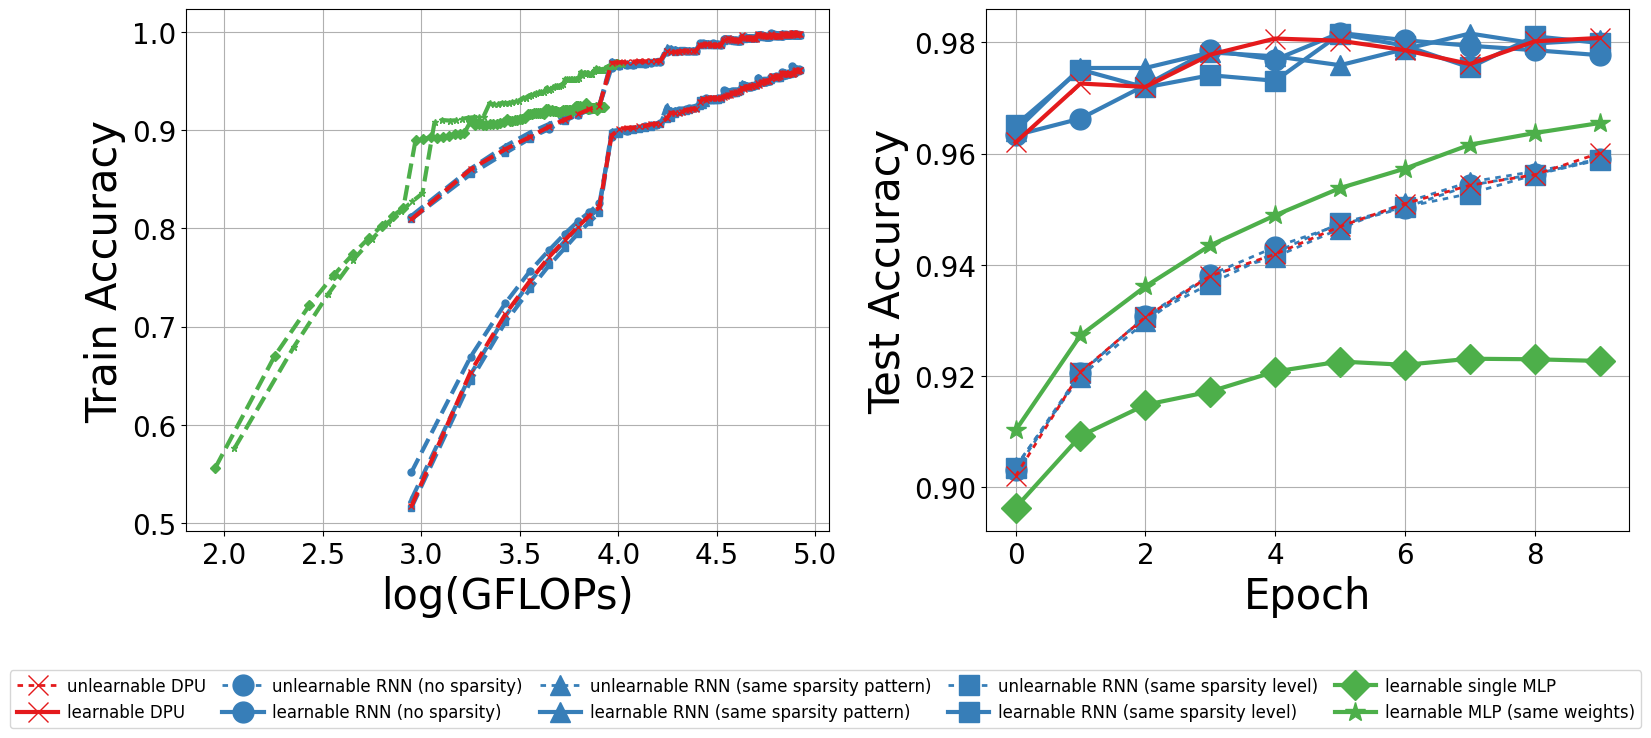

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

experiment_order = [
    "Static_BaseRNN", "Hungarian_RandInit_DrosoRef", "Hungarian_RandInit_RandSparseRef", "Hungarian_RandInit_RandStructureRef",
    "Learnable_BaseRNN", "Static_BaseRNN_random", "Static_BaseRNN_RandSparse", "Static_BaseRNN_RandStructure",
    "Single_MLP", "Twohidden_MLP"
]

def plot_results():
    results = {name: pickle.load(open(f"{name}.pkl", "rb")) for name in experiment_order}
  
    fig = plt.figure(figsize=(16, 11))
  
    colors = sns.color_palette('Set1', n_colors=10)
    
    type_colors = {
        'DPU': colors[0],    # Static_BaseRNN, Hungarian_RandInit_DrosoRef
        'RNN': colors[1],    # RNN related
        'MLP': colors[2]     # Single_MLP, Twohidden_MLP
    }
    
    labelname = {
        "Static_BaseRNN": "unlearnable DPU",
        "Hungarian_RandInit_DrosoRef": "learnable DPU",
        "Hungarian_RandInit_RandSparseRef": "learnable RNN (same sparsity level)",
        "Hungarian_RandInit_RandStructureRef": "learnable RNN (same sparsity pattern)",
        "Learnable_BaseRNN": "learnable RNN (no sparsity)",
        "Static_BaseRNN_random": "unlearnable RNN (no sparsity)",
        "Static_BaseRNN_RandSparse": "unlearnable RNN (same sparsity level)",
        "Static_BaseRNN_RandStructure": "unlearnable RNN (same sparsity pattern)",
        "Single_MLP": "learnable single MLP",
        "Twohidden_MLP": "learnable MLP (same weights)"
    }
    
    type_map = {
        "Static_BaseRNN": "DPU",
        "Hungarian_RandInit_DrosoRef": "DPU",
        "Hungarian_RandInit_RandSparseRef": "RNN",
        "Hungarian_RandInit_RandStructureRef": "RNN",
        "Learnable_BaseRNN": "RNN",
        "Static_BaseRNN_random": "RNN",
        "Static_BaseRNN_RandSparse": "RNN",
        "Static_BaseRNN_RandStructure": "RNN",
        "Single_MLP": "MLP",
        "Twohidden_MLP": "MLP"
    }
    
    # sparsity marker
    sparsity_markers = {
        'no sparsity': 'o',           # Learnable_BaseRNN, Static_BaseRNN_random
        'same sparsity pattern': '^', # Hungarian_RandInit_RandStructureRef, Static_BaseRNN_RandStructure
        'same sparsity level': 's',   # Hungarian_RandInit_RandSparseRef, Static_BaseRNN_RandSparse
        'DPU': 'x',                   # Static_BaseRNN, Hungarian_RandInit_DrosoRef
        'single MLP': 'D',            # Single_MLP
        'same weights MLP': '*'       # Twohidden_MLP
    }
    
    sparsity_level = {
        "Static_BaseRNN": "DPU",
        "Hungarian_RandInit_DrosoRef": "DPU",
        "Hungarian_RandInit_RandSparseRef": "same sparsity level",
        "Hungarian_RandInit_RandStructureRef": "same sparsity pattern",
        "Learnable_BaseRNN": "no sparsity",
        "Static_BaseRNN_random": "no sparsity",
        "Static_BaseRNN_RandSparse": "same sparsity level",
        "Static_BaseRNN_RandStructure": "same sparsity pattern",
        "Single_MLP": "single MLP",
        "Twohidden_MLP": "same weights MLP"
    }
    
    # learnable dash，unlearnable solid）
    linestyle_map = {
        True: ('--', 3),  
        False: ('-', 4)  
    }
    
    # FLOPs (log scale)
    # plot non-DPU
    plt.subplot(1, 2, 1)
    for name in experiment_order:
        if type_map[name] != "DPU":
            linestyle, lw = linestyle_map["learnable" in labelname[name]]
            flops = [x[0]/1e9 for x in results[name]['flops_acc']]
            acc = [x[1] for x in results[name]['flops_acc']]
            plt.plot(np.log10(flops), acc, linestyle, 
                     color=type_colors[type_map[name]], 
                     marker=sparsity_markers[sparsity_level[name]], 
                     label=labelname[name], lw=lw, markersize=5)
    # plot DPU, to overlap other lines
    for name in ["Static_BaseRNN", "Hungarian_RandInit_DrosoRef"]:
        linestyle, lw = linestyle_map["learnable" in labelname[name]]
        flops = [x[0]/1e9 for x in results[name]['flops_acc']]
        acc = [x[1] for x in results[name]['flops_acc']]
        plt.plot(np.log10(flops), acc, linestyle, 
                 color=type_colors[type_map[name]], 
                 marker=sparsity_markers[sparsity_level[name]], 
                 label=labelname[name], lw=lw, markersize=5, zorder=10)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("log(GFLOPs)", fontsize=fontsz)
    plt.ylabel("Train Accuracy", fontsize=fontsz)
    plt.grid(True)
    
    # test accuracy
    plt.subplot(1, 2, 2)
    # plot non-DPU
    for name in experiment_order:
        if type_map[name] != "DPU":
            linestyle, lw = linestyle_map["unlearnable" in labelname[name]]
            plt.plot(results[name]['epoch_test_acc'], linestyle, 
                     color=type_colors[type_map[name]], 
                     marker=sparsity_markers[sparsity_level[name]], 
                     label=labelname[name], lw=lw, markersize=15)
    # plot DPU, to overlap other lines
    for name in ["Static_BaseRNN", "Hungarian_RandInit_DrosoRef"]:
        linestyle, lw = linestyle_map["unlearnable" in labelname[name]]
        plt.plot(results[name]['epoch_test_acc'], linestyle, 
                 color=type_colors[type_map[name]], 
                 marker=sparsity_markers[sparsity_level[name]], 
                 label=labelname[name], lw=lw, markersize=15, zorder=10)
    plt.xlabel("Epoch", fontsize=fontsz)
    plt.ylabel("Test Accuracy", fontsize=fontsz)
    plt.grid(True)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.tight_layout(pad=2.0, h_pad=1.0)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    legend_order = [
        "unlearnable DPU", "learnable DPU",
        "unlearnable RNN (no sparsity)", "learnable RNN (no sparsity)",
        "unlearnable RNN (same sparsity pattern)", "learnable RNN (same sparsity pattern)",
        "unlearnable RNN (same sparsity level)", "learnable RNN (same sparsity level)",
        "learnable single MLP", "learnable MLP (same weights)"
    ]
    handles_sorted = []
    labels_sorted = []
    for label in legend_order:
        if label in labels:
            idx = labels.index(label)
            handles_sorted.append(handles[idx])
            labels_sorted.append(label)
    
    for i, handle in enumerate(handles_sorted):
        if "unlearnable" in labels_sorted[i]:
            handle.set_linestyle('--')  
            handle.set_dashes((2, 2))   
            handle.set_linewidth(2)    
        else:
            handle.set_linestyle('-') 
            handle.set_linewidth(3)  
    
    plt.legend(handles_sorted, labels_sorted, 
               bbox_to_anchor=(-0.25, -0.25), loc='upper center', 
               ncol=5, fontsize=12, columnspacing=1.0, handletextpad=0.5, 
               handlelength=2.5)
    
    plt.subplots_adjust(bottom=0.5)
    plt.savefig("all_metrics.png", dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    fontsz = 30
    plot_results()

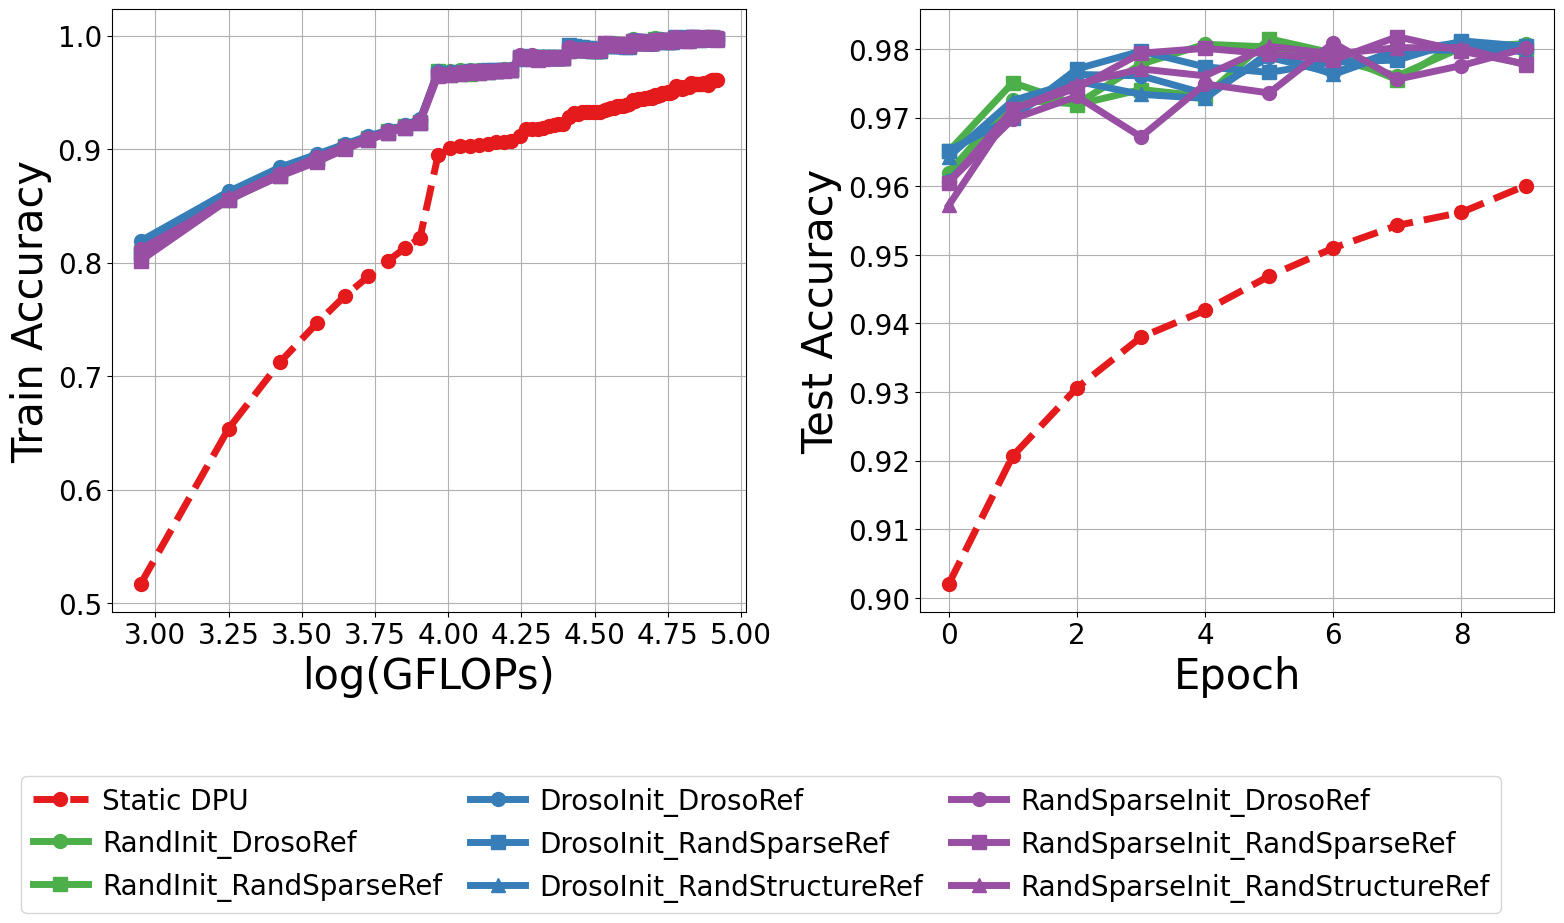

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

experiment_order = [
    "Static_BaseRNN", 
    "Hungarian_RandInit_DrosoRef", "Hungarian_RandInit_RandSparseRef",
    "Hungarian_DrosoInit_DrosoRef", "Hungarian_DrosoInit_RandSparseRef", "Hungarian_DrosoInit_RandStructureRef",
    "Hungarian_RandSparseInit_DrosoRef", "Hungarian_RandSparseInit_RandSparseRef", "Hungarian_RandSparseInit_RandStructureRef"
]

def plot_results():
    results = {name: pickle.load(open(f"{name}.pkl", "rb")) for name in experiment_order}
  
    fig = plt.figure(figsize=(16, 9))
  
    colors = sns.color_palette('Set1')
    
    w_init_colors = {
        'rnn': colors[0],      # blue
        'droso':colors[1], 
        'random': colors[2],     # orange
        'randsparse': colors[3]  # green
    }
    
    w_ref_markers = {
        'rnn': '',  
        'droso': 'o',           # circle
        'randsparse': 's',      # square
        'randstructure': '^'    # triangle
    }
    
    trainable_linestyles = {
        True: '-',  
        False: '--' 
    }
    
    labelname = {
        "Static_BaseRNN": "Static DPU",
        "Hungarian_RandInit_DrosoRef": "RandInit_DrosoRef",
        "Hungarian_RandInit_RandSparseRef": "RandInit_RandSparseRef",
        "Hungarian_DrosoInit_DrosoRef": "DrosoInit_DrosoRef",
        "Hungarian_DrosoInit_RandSparseRef": "DrosoInit_RandSparseRef",
        "Hungarian_DrosoInit_RandStructureRef": "DrosoInit_RandStructureRef",
        "Hungarian_RandSparseInit_DrosoRef": "RandSparseInit_DrosoRef",
        "Hungarian_RandSparseInit_RandSparseRef": "RandSparseInit_RandSparseRef",
        "Hungarian_RandSparseInit_RandStructureRef": "RandSparseInit_RandStructureRef"
    }
    
    w_init_map = {
        "Static_BaseRNN": "rnn",
        "Hungarian_RandInit_DrosoRef": "random",
        "Hungarian_RandInit_RandSparseRef": "random",
        "Hungarian_DrosoInit_DrosoRef": "droso",
        "Hungarian_DrosoInit_RandSparseRef": "droso",
        "Hungarian_DrosoInit_RandStructureRef": "droso",
        "Hungarian_RandSparseInit_DrosoRef": "randsparse",
        "Hungarian_RandSparseInit_RandSparseRef": "randsparse",
        "Hungarian_RandSparseInit_RandStructureRef": "randsparse"
    }
    
    w_ref_map = {
        "Static_BaseRNN": "droso",
        "Hungarian_RandInit_DrosoRef": "droso",
        "Hungarian_RandInit_RandSparseRef": "randsparse",
        "Hungarian_DrosoInit_DrosoRef": "droso",
        "Hungarian_DrosoInit_RandSparseRef": "randsparse",
        "Hungarian_DrosoInit_RandStructureRef": "randstructure",
        "Hungarian_RandSparseInit_DrosoRef": "droso",
        "Hungarian_RandSparseInit_RandSparseRef": "randsparse",
        "Hungarian_RandSparseInit_RandStructureRef": "randstructure"
    }
    
    trainable_map = {
        "Static_BaseRNN": False,
        "Hungarian_RandInit_DrosoRef": True,
        "Hungarian_RandInit_RandSparseRef": True,
        "Hungarian_DrosoInit_DrosoRef": True,
        "Hungarian_DrosoInit_RandSparseRef": True,
        "Hungarian_DrosoInit_RandStructureRef": True,
        "Hungarian_RandSparseInit_DrosoRef": True,
        "Hungarian_RandSparseInit_RandSparseRef": True,
        "Hungarian_RandSparseInit_RandStructureRef": True
    }
    
    plt.subplot(1, 2, 1)
    for name in experiment_order:
        flops = [x[0]/1e9 for x in results[name]['flops_acc']]
        acc = [x[1] for x in results[name]['flops_acc']]
        plt.plot(np.log10(flops), acc, 
                 linestyle=trainable_linestyles[trainable_map[name]], 
                 color=w_init_colors[w_init_map[name]], 
                 marker=w_ref_markers[w_ref_map[name]], 
                 label=labelname[name], lw=5, markersize=10)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("log(GFLOPs)", fontsize=fontsz)
    plt.ylabel("Train Accuracy", fontsize=fontsz)
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    for name in experiment_order:
        plt.plot(results[name]['epoch_test_acc'], 
                 linestyle=trainable_linestyles[trainable_map[name]], 
                 color=w_init_colors[w_init_map[name]], 
                 marker=w_ref_markers[w_ref_map[name]], 
                 label=labelname[name], lw=5, markersize=10)
    plt.xlabel("Epoch", fontsize=fontsz)
    plt.ylabel("Test Accuracy", fontsize=fontsz)
    plt.grid(True)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.tight_layout(pad=2.0, h_pad=1.0)
    plt.legend(bbox_to_anchor=(-0.25, -0.25), loc='upper center', ncol=3, fontsize=fontsz-10, 
               columnspacing=1.0, handletextpad=0.5)
    
    plt.subplots_adjust(bottom=0.3)
    plt.savefig("all_metrics.png", dpi=300, bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    fontsz = 30
    plot_results()